## IMPORT PACKAGES

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
import numpy as np
import os

sys.path.append('../../')
from utils import microarray_utils, clustering_utils, bokeh_ui_utils_final, file_utils

In [2]:
z=False
expr_min=0
expr_max=1

In [3]:
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=z)
full_filtered_norm_df = microarray_utils.get_arith_mean_expression(full_filtered_norm_df)

num_genes = full_filtered_df.shape[0]
num_genes

In [ ]:
microarray_utils.get_arith_mean_expression(full_filtered_df.loc[full_filtered_df['TTHERM_ID'] == 'TTHERM_00092820'])

,TTHERM_ID,Ll,Lm,Lh,S0,S3,S6,S9,S15,S24,C0,C4,C6,C8,C10,C12,C14,C16,C18
0,TTHERM_00092820,8.987879,7.874006,9.827421,10.435008,10.973612,9.908008,7.424122,5.975709,6.270757,9.581992,11.057798,9.977235,6.277593,6.203402,8.388375,9.392406,10.653901,10.484627


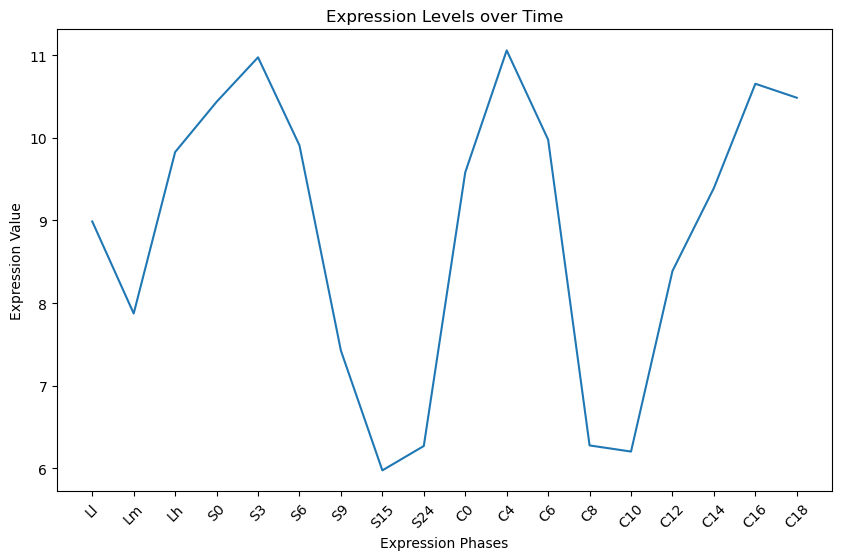

In [ ]:
df = microarray_utils.get_arith_mean_expression(full_filtered_df.loc[full_filtered_df['TTHERM_ID'] == 'TTHERM_00092820'])

phases = list(df.columns)[1:]
expression_values = [df[col].values[0] for col in list(df.columns)[1:]] 

plt.figure(figsize=(10, 6))  

plt.plot(phases, expression_values, linestyle='-')  

plt.xlabel("Expression Phases")
plt.ylabel("Expression Value")
plt.title("Expression Levels over Time")

plt.xticks(rotation=45)  

plt.show()

In [ ]:
veg_cols = [col for col in full_filtered_df.columns if col[0] != 'C']
veg_filtered_df = full_filtered_df[veg_cols]
veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=z)
veg_filtered_norm_df = microarray_utils.get_arith_mean_expression(veg_filtered_norm_df)

In [ ]:
sex_cols = [col for col in full_filtered_df.columns if col[0] == 'C']
sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=z)
sex_filtered_norm_df = microarray_utils.get_arith_mean_expression(sex_filtered_norm_df)

In [ ]:
sex_filtered_norm_df.columns

Index(['TTHERM_ID', 'C0', 'C4', 'C6', 'C8', 'C10', 'C12', 'C14', 'C16', 'C18'], dtype='object')

In [ ]:
veg_filtered_norm_df.columns

Index(['TTHERM_ID', 'Ll', 'Lm', 'Lh', 'S0', 'S3', 'S6', 'S9', 'S15', 'S24'], dtype='object')

In [ ]:
np.min(veg_filtered_norm_df[veg_filtered_norm_df.columns[1:]]), np.max(sex_filtered_norm_df[sex_filtered_norm_df.columns[1:]])

(2.0965002925841054e-05, 0.9999726639972383)

# LEIDEN CLUSTERING

In [ ]:
phases_list = ['full', 'veg', 'sex']
phases = 'full'

In [ ]:
metric = 'manhattan'
# metric='minkowski_3.0'

resolution_param=0.005
# resolution_param=0.0001

n_neighbors = 3

dataset = 'microarray'

In [ ]:
# Moving normalization from within the function to before the function
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_norm_df,
    dataset,
    metric=metric,
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [ ]:
full_filtered_norm_df.head()

,TTHERM_ID,Ll,Lm,Lh,S0,S3,S6,S9,S15,S24,C0,C4,C6,C8,C10,C12,C14,C16,C18
0,TTHERM_00000010,0.060127,0.087992,0.151873,0.645489,0.648679,0.772457,0.721339,0.351385,0.475216,0.925139,0.287005,0.185431,0.261260,0.227479,0.276787,0.469973,0.445911,0.455328
1,TTHERM_00000020,0.065319,0.248918,0.327624,0.957095,0.558248,0.544104,0.354524,0.155189,0.213445,0.574770,0.337529,0.200868,0.178356,0.164982,0.182591,0.191430,0.306061,0.159140
2,TTHERM_00000030,0.038844,0.067896,0.111175,0.831943,0.417995,0.654550,0.491450,0.113417,0.074563,0.177236,0.216990,0.092500,0.039891,0.065043,0.078270,0.060898,0.033863,0.061245
3,TTHERM_00000040,0.356047,0.482429,0.539785,0.630862,0.504858,0.392717,0.469180,0.572015,0.587845,0.501566,0.500706,0.553403,0.347498,0.055787,0.138398,0.265694,0.317272,0.368884
4,TTHERM_00000047,0.644835,0.612958,0.485325,0.355717,0.454049,0.380141,0.546721,0.542593,0.604214,0.179979,0.729279,0.532437,0.962852,0.514455,0.710594,0.832461,0.467284,0.480008


In [ ]:
leiden_label_df_round_1_arranged = bokeh_ui_utils_final.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

In [ ]:
avg_full_filtered_norm_df = clustering_utils.ari_mean_nexpr_per_mod(full_filtered_norm_df, leiden_label_df_round_1_arranged_sorted)

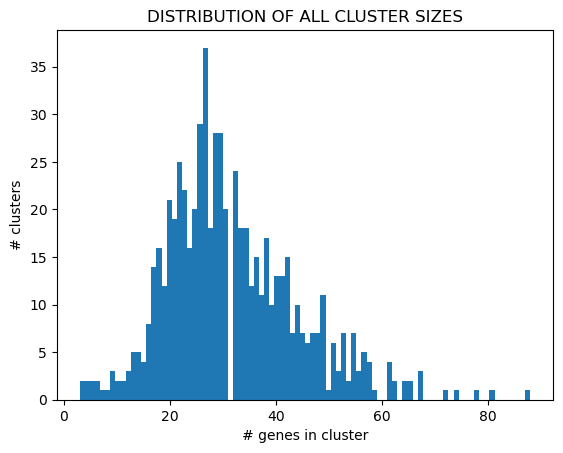

In [ ]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

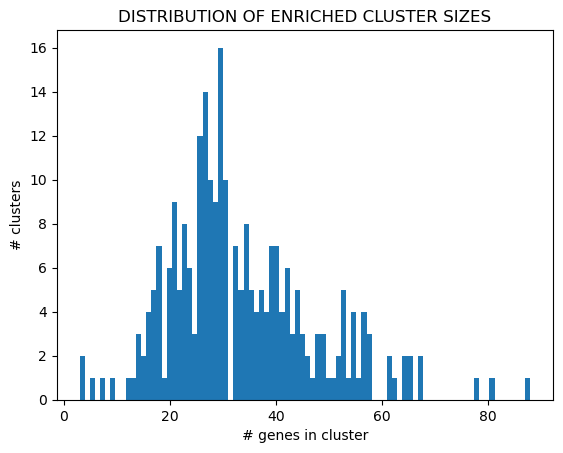

In [ ]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [ ]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.02571125591543203
                  modularity: 0.7691997404424847
                   nclusters: 645
           mean_cluster_size: 31.71627906976744
         median_cluster_size: 30.0
             sd_cluster_size: 12.528855319303618
          nenriched_clusters: 253
  mean_enriched_cluster_size: 33.541501976284586
median_enriched_cluster_size: 30.0
    sd_enriched_cluster_size: 13.769820673503009
     nenriched_cluster_genes: 8486
                    datetime: 2024-06-28 10:02:18.572939


In [ ]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [ ]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [ ]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [ ]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [ ]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [ ]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [ ]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [ ]:
# yf_to_ttherm_map_df = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_may2024.csv')
# yf_to_ttherm_map_df.rename(columns={'TTHERM_ID': 'TTHERM_IDs', 'YF_ID': 'TTHERM_ID'},inplace=True)
yf_to_ttherm_map_df = None

In [ ]:
embedding_metric='manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils_final.generate_and_save_umap(dashboard_path, full_filtered_norm_df, enrich_full_nn3, complete_annot, leiden_label_df_round_1_arranged_sorted, phases, color_palette, os.path.basename(dashboard_path), expr_min=expr_min, expr_max=expr_max, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df, avg_df=avg_full_filtered_norm_df)

/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils_final.py:612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].va


            // console.log(plot_tabs.active);
            if (plot_tabs.active == 0){
            var avg_idxs = cb_obj.indices;
            var d1 = s1.data; // embedding
            var d2 = s2.data; // table
            var d_avg = s_avg.data

            var d_expr = s_expr.data; // expression plot
            var d_hm = s_hm.data; // heatmap
            var d_enrich = s_enrich.data; // enrichment plot

            var selected_ttherm_id = "";

            var ttids = d_hm['TTHERM_ID'].slice(0, 20457);
            const num_cols = cols.length;

            d2['module'] = []
            d2['ID'] = []


            // JS INITIALIZE

            // EMBEDDING
            // Start by making everything tiny and pale
            // d1['alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['line_alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['radius'] = Array(d1['ID'].length).fill(0.0001)

            // TABLE
            d2['ID'] = []
            // d2['YF_ID'] = [

In [ ]:
def run_over_all_phases(metric='manhattan', 
                        resolution_param=0.005, 
                        n_neighbors=3,
                        dataset='microarray'
                        ):


    with open(('colors_2000_1'), 'rb') as file:
        color_palette_raw = pickle.load(file)

    color_palette = palette65

    complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')
    phases_list = ['full', 'veg', 'sex']

    full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
    full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
    full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=z)
    full_filtered_norm_df = microarray_utils.get_arith_mean_expression(full_filtered_norm_df)

    veg_cols = [col for col in full_filtered_df.columns if col[0] != 'C']
    veg_filtered_df = full_filtered_df[veg_cols]
    veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=z)
    veg_filtered_norm_df = microarray_utils.get_arith_mean_expression(veg_filtered_norm_df)

    sex_cols = [col for col in full_filtered_df.columns if col[0] == 'C']
    sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
    sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=z)
    sex_filtered_norm_df = microarray_utils.get_arith_mean_expression(sex_filtered_norm_df)

    metric = metric
    # metric='minkowski_3.0'

    resolution_param=resolution_param
    # resolution_param=0.0001

    n_neighbors = n_neighbors

    dataset = dataset



    for phase, ndf in zip(phases_list, [full_filtered_norm_df, veg_filtered_norm_df, sex_filtered_norm_df]):

        leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
            ndf,
            dataset,
            metric=metric,
            n_neighbors=n_neighbors, 
            resolution_param=resolution_param, 
            partition_type = 'EXP', 
            n_jobs = -1, 
            random_state=42
        )
        
        print()
        print(phase)

        key_lens = [len(k) for k in partition_stats.keys()]
        max_key_len = max(key_lens)

        for k, v in partition_stats.items():
            print(f'{" " * (max_key_len - len(k))}{k}:', v)

        print()

        
        leiden_label_df_round_1_arranged = bokeh_ui_utils_final.arrange_modules(
            ndf, 
            leiden_label_df_round_1, 
            phase
        )

        leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)

        avg_full_filtered_norm_df = clustering_utils.ari_mean_nexpr_per_mod(ndf, leiden_label_df_round_1_arranged_sorted)

        # leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

        enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

        # outfile='../enrichment/test_nn3_full_enrichment.csv'
        # enrich_full_nn3.to_csv(outfile, index=False)

        embedding_metric='manhattan'

        dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

        if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
            color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

        p = bokeh_ui_utils_final.generate_and_save_umap(dashboard_path, ndf, enrich_full_nn3, complete_annot, leiden_label_df_round_1_arranged_sorted, phase, color_palette, os.path.basename(dashboard_path), expr_min=expr_min, expr_max=expr_max, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df, avg_df=avg_full_filtered_norm_df)

    

    
    

In [ ]:
run_over_all_phases()


full
              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.02571125591543203
                  modularity: 0.7691997404424847
                   nclusters: 645
           mean_cluster_size: 31.71627906976744
         median_cluster_size: 30.0
             sd_cluster_size: 12.528855319303618
          nenriched_clusters: 253
  mean_enriched_cluster_size: 33.541501976284586
median_enriched_cluster_size: 30.0
    sd_enriched_cluster_size: 13.769820673503009
     nenriched_cluster_genes: 8486
                    datetime: 2024-06-28 10:05:07.371296



/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils_final.py:612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].va


            // console.log(plot_tabs.active);
            if (plot_tabs.active == 0){
            var avg_idxs = cb_obj.indices;
            var d1 = s1.data; // embedding
            var d2 = s2.data; // table
            var d_avg = s_avg.data

            var d_expr = s_expr.data; // expression plot
            var d_hm = s_hm.data; // heatmap
            var d_enrich = s_enrich.data; // enrichment plot

            var selected_ttherm_id = "";

            var ttids = d_hm['TTHERM_ID'].slice(0, 20457);
            const num_cols = cols.length;

            d2['module'] = []
            d2['ID'] = []


            // JS INITIALIZE

            // EMBEDDING
            // Start by making everything tiny and pale
            // d1['alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['line_alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['radius'] = Array(d1['ID'].length).fill(0.0001)

            // TABLE
            d2['ID'] = []
            // d2['YF_ID'] = [

/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils_final.py:612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].va


            // console.log(plot_tabs.active);
            if (plot_tabs.active == 0){
            var avg_idxs = cb_obj.indices;
            var d1 = s1.data; // embedding
            var d2 = s2.data; // table
            var d_avg = s_avg.data

            var d_expr = s_expr.data; // expression plot
            var d_hm = s_hm.data; // heatmap
            var d_enrich = s_enrich.data; // enrichment plot

            var selected_ttherm_id = "";

            var ttids = d_hm['TTHERM_ID'].slice(0, 20457);
            const num_cols = cols.length;

            d2['module'] = []
            d2['ID'] = []


            // JS INITIALIZE

            // EMBEDDING
            // Start by making everything tiny and pale
            // d1['alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['line_alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['radius'] = Array(d1['ID'].length).fill(0.0001)

            // TABLE
            d2['ID'] = []
            // d2['YF_ID'] = [

/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/tgne_all.env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils_final.py:612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].va


            // console.log(plot_tabs.active);
            if (plot_tabs.active == 0){
            var avg_idxs = cb_obj.indices;
            var d1 = s1.data; // embedding
            var d2 = s2.data; // table
            var d_avg = s_avg.data

            var d_expr = s_expr.data; // expression plot
            var d_hm = s_hm.data; // heatmap
            var d_enrich = s_enrich.data; // enrichment plot

            var selected_ttherm_id = "";

            var ttids = d_hm['TTHERM_ID'].slice(0, 20457);
            const num_cols = cols.length;

            d2['module'] = []
            d2['ID'] = []


            // JS INITIALIZE

            // EMBEDDING
            // Start by making everything tiny and pale
            // d1['alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['line_alpha'] = Array(d1['ID'].length).fill(0.01)
            // d1['radius'] = Array(d1['ID'].length).fill(0.0001)

            // TABLE
            d2['ID'] = []
            // d2['YF_ID'] = [